In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
trans_df = pd.read_csv('../data/credit_card_fraud_data_v2.csv')

In [3]:
trans_df.shape

(6372620, 11)

In [4]:
trans_df.columns

Index(['Time_Stamp', 'Transaction_Type', 'Amount', 'Client_Id',
       'Client_Old_Balance', 'Cleint_New_Balance', 'Merchant_Id',
       'Merchant_Old_Balance', 'Merchant_New_Balance', 'Is_Fraud',
       'Is_Flagged_Fraud'],
      dtype='object')

In [5]:
trans_df.head()

,Time_Stamp,Transaction_Type,Amount,Client_Id,Client_Old_Balance,Cleint_New_Balance,Merchant_Id,Merchant_Old_Balance,Merchant_New_Balance,Is_Fraud,Is_Flagged_Fraud
0,1,BILL-PAYMENT,9839.64,C494672677,170136.0,160296.36,M582455116,0.0,0.0,0,0
1,1,BILL-PAYMENT,1864.28,C502607876,21249.0,19384.72,C214000796,0.0,0.0,0,0
2,1,PURCHASE,181.00,C633112680,181.0,0.00,M1922059099,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C1993768127,181.0,0.00,M245426835,21182.0,0.0,1,0
4,1,BILL-PAYMENT,11668.14,C1445837831,41554.0,29885.86,M1368211346,0.0,0.0,0,0


In [5]:
bal_diff = trans_df['Client_Old_Balance'] - trans_df['Cleint_New_Balance']
bal_diff = bal_diff.abs()

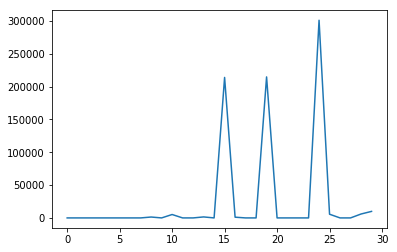

In [14]:
plt.plot(np.abs(trans_df['Amount'] - bal_diff)[:30])

### Number of Fraud Cases: 0.3 % !!!!!

In [7]:
trans_df['Is_Fraud'].sum()

18213

### Number of Unique Clients

In [8]:
trans_df['Client_Id'].unique().shape

(952147,)

### Number of Unique Merchants

In [9]:
trans_df['Merchant_Id'].unique().shape

(522360,)

### Range of Trans. Amount Values

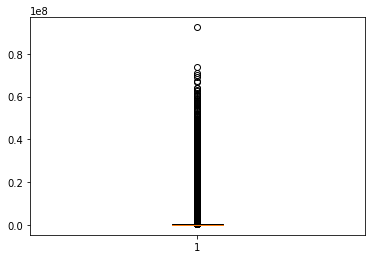

In [11]:
plt.boxplot(trans_df['Amount'])
plt.show()

In [13]:
trans_df['Amount'].max()

92445516.64

In [14]:
trans_df['Amount'].min()

0.0

In [16]:
np.sum(np.abs(trans_df['Is_Fraud'].values - trans_df['Is_Flagged_Fraud'].values))

18197

In [18]:
trans_df['Is_Flagged_Fraud'].sum()

16

### Transaction Type When Fraud

In [15]:
fraud_trans = trans_df[trans_df.Is_Fraud == 1]['Transaction_Type']

In [19]:
np.sum(fraud_trans == 'CASH_OUT')

9116

In [20]:
np.sum(fraud_trans == 'PURCHASE')

9097